In [48]:
# ## A small ChatGPT style Transformer
# * concepts in NLP and Transformers 
# * generative mdoels
# https://github.com/rcalix1/PyTorch/blob/main/DeepLearning/Transformers/GPTs/GenerativeTransformerTinyGPT.py

############################################################ 

import torch
import numpy as np
import requests
## import tiktoken
import torch.nn as nn
import copy
import pandas as pd
import time

from torch.nn import functional as F

############################################################

## !pip install requests
## !pip install tiktoken    ## requires python   >    3.9

############################################################

torch.manual_seed(1337)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

############################################################

input_file_path = 'input.txt'

## data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

with open(input_file_path, 'r', encoding='utf-8') as f:
    text = f.read()
    
############################################################

print("length of data in characters")
len(text)

############################################################

chars = sorted(     list(set(text))   )

vocab_size = len(chars)

print(  ''.join(chars)  )

############################################################# 
## tokenizer

stoi = { ch:i for i, ch in enumerate(chars) }
itos = { i:ch for i, ch in enumerate(chars) }

encode = lambda s: [ stoi[c]          for c in s   ]    ## encoder: string to integer
decode = lambda l: ''.join(   itos[i] for i in l   )    ## decoder: interger to string

#############################################################

data = torch.tensor(   encode(text), dtype=torch.long   )
n    = int(   0.9*len(data)   )
train_data = data[:n]
val_data   = data[n:]

#############################################################

def get_batch(split):
    if split == "train":
        data = train_data
    else:
        data = val_data
    ix = torch.randint(   len(data) - block_size, (batch_size,)   )
    x  = torch.stack(    [  data[ i : i+block_size ]   for i in ix]    ) 
    y  = torch.stack(    [  data[ i+1 : i+1+block_size ]   for i in ix]    )
    
    x, y = x.to(device), y.to(device)

    return x, y

############################################################


@torch.no_grad()    ## for efficiency
def estimate_loss(model,only_validation=False):
    out = {}
    model.eval()   ## no training
    if only_validation:
        arr=[ 'val']
    else:
        arr=['train', 'val']
    for split in arr:
        print("split",split)
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            # print(k,range(eval_iters))
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()  ## back to training
    return out

##########################################################################################


class Head(nn.Module):
    """ one head of self-attention """
    
    def __init__(self, head_size):
        super().__init__()
        self.key   = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        
        ## the mask tril is not part of the graph since only for masking
        ## so register buffer makes it a thing out of the graph
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)              ## (B, T, C)
        q = self.query(x)            ## (B, T, C)
        
        wei = q @ k.transpose(-2, -1) * C**-0.5       ## (B, T, C) @ (B, C, T)  -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))     ## (B, T, T)
        wei = F.softmax(wei, dim= -1)           ## (B, T, T)
        wei = self.dropout(   wei   )
        
        ## perform the weighted aggregation of the values
        v   = self.value(  x  )   ## (B, T, C)
        out = wei @ v             ## (B, T, T) @ (B, T, C) -> (B, T, C)
        
        return out
        
##########################################################################################


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList(  [Head(head_size) for _ in range(num_heads) ] )
        self.proj  = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out

##########################################################################################

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)

##########################################################################################

class Block(nn.Module):
    """ Transformer block: comuunication followed by computation """
    
    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward( n_embd)
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        ## these normalizations (ln1, ln2) are about the only thing different from
        ## the original Vaswani paper. In the paper, they are done at the end of forward
        ## but now they are usually done at the beginning of forward
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x
    
##########################################################################################


class BigramLanguageModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)     ## positional encoding 
        self.blocks = nn.Sequential(
                *[   Block(n_embd, n_head=n_head) for _ in range(n_layer)    ]
        )
        self.ln_f    = nn.LayerNorm(  n_embd    )        ## final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    
    def forward(self, idx, targets=None):
        
        B, T = idx.shape
        
        ## ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(idx)      ## batch, time, embed (4, 8, 32) 
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))      ## (T, C)
        x = tok_emb + pos_emb    ## (B, T, C)
        x = self.blocks(  x  )   ## (B, T, C)        
        x = self.ln_f(x)         ## (B, T, C)
        logits = self.lm_head(x)                 ## (B, T, vocab_sice)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits  = logits.view(B*T, C)
            targets  = targets.view(B*T)
            loss   = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        
        ## idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            
            ## crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            ## get the predictions
            logits, loss = self(idx_cond)
            ## focus only on last time stamp
            logits = logits[:, -1, :]           ## becomes (B, C)
            ## apply softmax to get probs
            probs = F.softmax(logits, dim= -1)    ## (B, C)
            ## sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1)
            ## append sample to the running sequence
            idx = torch.cat(  (idx, idx_next), dim=1  )            ## (B, T+1)
        return idx
            
            
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calc_compression(model):
    total=0
    total_zero=0
    for p in model.parameters(): 
        if p.requires_grad:
            total+=p.numel()
            total_zero+=(p.numel()-torch.count_nonzero(p).item())
    return total_zero/total

            
def set_one_if_non_zero(model):
    for p in model.parameters(): 
        if p.requires_grad:            
            p.data[p.data!=0]=1


def set_zero(model):
    for p in model.parameters(): 
        if p.requires_grad:
            p.data=torch.zeros(p.shape)

def sum_till_n(n):
    sum_val=0
    for i in range(n):
        sum_val+=i
    return sum_val
def update_weights(m_src,m_dest,epochNum):
    sum_val_prev=sum_till_n(epochNum+1)
    sum_val=sum_till_n(epochNum+2)
    # print(sum_val_prev,sum_val)
    # as epochNum starts from 1
    # we consider that the epochnum starts from 0
    print_turn=0
    for p_src,q_dest in zip(m_src.parameters(), m_dest.parameters()):
        
        if p_src.requires_grad and q_dest.requires_grad:
            # print(p_src.data.shape,q_dest.data.shape)
            prev_total=q_dest.data*sum_val_prev
            new_vals=p_src.data*(epochNum+1)
            new_average=(prev_total+new_vals)/sum_val
            q_dest.data=new_average
            # if print_turn==0:
            #     # print(sum_val_prev,sum_val)
            #     print(p_src.data[0][0])
            #     print(new_average[0][0])
            # print_turn+=1
                        



length of data in characters

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [2]:
######################################################################

n_embd  = 384                  ## every id gets embedded to vector of this size
n_head  = 6
n_layer = 6
dropout = 0.0
block_size = 256      ## max content length for predictions
learning_rate = 3e-4             ## 0.001



######################################################################



In [3]:
eval_iters = 200
batch_size = 64 
# losses = estimate_loss(model_original,only_validation=True)
# print(f"original model {losses}")

In [6]:
# calc_compression(model_original)

In [7]:
def prune_model(model_actual,model_gradient,prune_rate=0.282):
    for p_ori,q_gradw in zip(model_actual.parameters(), model_gradient.parameters()):
            
            if p_ori.requires_grad and q_gradw.requires_grad:
                # print(p_ori.shape,q_gradw.shape)
                q_gradw_abs=torch.abs(q_gradw.data)
                thresh=torch.std(q_gradw_abs)*prune_rate
                # print(thresh)
                p_ori.data[q_gradw_abs<thresh]=0
    
    # print(f" After pruning, {calc_compression(model_actual)}")    

In [8]:
    




# # prune weights here
# prune_rate=0.282
# for p_ori,q_gradw in zip(model_original.parameters(), model_wtd_gradients.parameters()):
        
#         if p_ori.requires_grad and q_gradw.requires_grad:
#             # print(p_ori.shape,q_gradw.shape)
#             q_gradw_abs=torch.abs(q_gradw.data)
#             thresh=torch.std(q_gradw_abs)*prune_rate
#             # print(thresh)
#             p_ori.data[q_gradw_abs<thresh]=0

# print(f" After pruning, {calc_compression(model_original)}")

In [9]:
prune_rates=[
    0.247,0.5,0.75,1.01,1.3,1.575,
    1.9,
    2.289,
    2.85,
    3.2
    
    
    
]

dic_results={}
dic_results["prune_rate"]=[]
dic_results["compression"]=[]
dic_results["loss"]=[]

for prune_rate in prune_rates:
    
    model_original   = BigramLanguageModel()
    model_wtd_gradients   = BigramLanguageModel()
    model_original = model_original.to(device)
    model_wtd_gradients = model_wtd_gradients.to(device)
        
    ## Load the weights from local
    max_iters  = 5000
    model_path = f'model_parameters_{max_iters}.pth'
    model_original.load_state_dict(torch.load(model_path, map_location=device))
    # print(f"The model has {count_parameters(model_original):,} trainable parameters")            
    
    max_iters  = 5000
    model_path = f'model_gradient_parameters_{max_iters}.pth'
    model_wtd_gradients.load_state_dict(torch.load(model_path, map_location=device))
    # print(f"The model has {count_parameters(model_wtd_gradients):,} trainable parameters")            
    
    
    
    # fine tune with freezing
    max_iters  = 50
    
    prune_model(model_original,model_wtd_gradients,prune_rate=prune_rate)
    print(f" After pruning,{prune_rate} coompression= {calc_compression(model_original)}")


    optimizer = torch.optim.Adam(  model_original.parameters(), lr=learning_rate   )
    print("Fine tuning with mask")
    for iter in range(max_iters):
        
        
        xb, yb = get_batch('train')
        
        ## evaluate the loss
        logits, loss = model_original(xb, yb)
        optimizer.zero_grad(set_to_none=True)   ## zero out
        loss.backward()
        optimizer.step()
        prune_model(model_original,model_wtd_gradients,prune_rate=prune_rate)
     
        # end=time.time()
        # print("one iter",end-start)
        
    losses = estimate_loss(model_original,only_validation=True)
    compre=calc_compression(model_original)
    print(f" After pruning, {compre}")
    print(f"pruned original model loss: {losses}")
    dic_results["prune_rate"].append(prune_rate)
    dic_results["compression"].append(compre)
    dic_results["loss"].append(losses["val"].item())
        

 After pruning,0.247 coompression= 0.1001000191956032
Fine tuning with mask
split val
 After pruning, 0.1001000191956032
pruned original model loss: {'val': tensor(1.9776)}
 After pruning,0.5 coompression= 0.20186628348374525
Fine tuning with mask
split val
 After pruning, 0.20186628348374525
pruned original model loss: {'val': tensor(1.9330)}
 After pruning,0.75 coompression= 0.3006526412399229
Fine tuning with mask
split val
 After pruning, 0.3006526412399229
pruned original model loss: {'val': tensor(1.8640)}
 After pruning,1.01 coompression= 0.40024881060946826
Fine tuning with mask
split val
 After pruning, 0.40024881060946826
pruned original model loss: {'val': tensor(1.7824)}
 After pruning,1.3 coompression= 0.506503750279569
Fine tuning with mask
split val
 After pruning, 0.506503750279569
pruned original model loss: {'val': tensor(1.6936)}
 After pruning,1.575 coompression= 0.6005795385250936
Fine tuning with mask
split val
 After pruning, 0.6005795385250936
pruned original mo

In [12]:
import pandas as pd
df=pd.DataFrame(dic_results)

In [77]:
df

,prune_rate,compression,loss
0,0.247,0.100100,1.977640
1,0.500,0.201866,1.932997
2,0.750,0.300653,1.864001
3,1.010,0.400249,1.782435
4,1.300,0.506504,1.693631
5,1.575,0.600580,1.656231
6,1.900,0.700947,1.747863
7,2.289,0.801467,2.133086
8,2.850,0.903553,2.703286
9,3.200,0.942847,3.098182


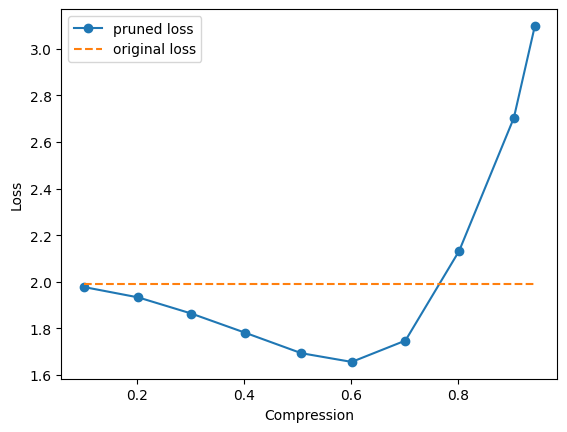

In [79]:
import matplotlib.pyplot as plt

plt.plot(df["compression"],df["loss"],'-o',label="pruned loss")
plt.plot(df["compression"],[1.99 for i in range(len(df["compression"]))],'--',label="original loss")
plt.xlabel("Compression")
plt.ylabel("Loss")
plt.legend()

# plt.title("Loss Vs Pruned compression of model with 10 million parameters")
plt.savefig("results/lossVprune.png")
plt.savefig("results/lossVprune.pdf")
plt.savefig("results/lossVprune.svg")
plt.show()



In [14]:
df.to_csv("results/prune_performance_tinyGPT.csv",index=False)

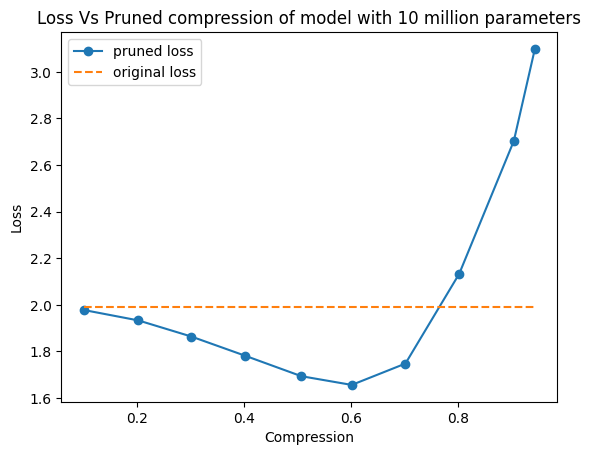

In [27]:
import matplotlib.pyplot as plt

plt.plot(df["compression"],df["loss"],'-o',label="pruned loss")
plt.plot(df["compression"],[1.99 for i in range(len(df["compression"]))],'--',label="original loss")
plt.xlabel("Compression")
plt.ylabel("Loss")
plt.legend()

plt.title("Loss Vs Pruned compression of model with 10 million parameters")
plt.savefig("results/lossVprune.png")
plt.savefig("results/lossVprune.pdf")
plt.savefig("results/lossVprune.svg")
plt.show()



In [58]:
def apply_threshold_fuse_get_mask(model_original,mask_model_clone,thresh_fuse):
    for p_src,q_dest in zip(model_original.parameters(), mask_model_clone.parameters()):        
        if p_src.requires_grad and q_dest.requires_grad:
            # print(p_src.data.shape,q_dest.data.shape)
            for i in range(p_src.data.shape[0]):
                comp_src=p_src.data[i]
                comp_mask=q_dest.data[i]
                comp=(torch.numel(comp_src)-torch.count_nonzero(comp_src))/(torch.numel(comp_src))
                if comp>thresh_fuse:
                    # print("\t",comp)
                    q_dest.data[i]=torch.zeros(q_dest.data[i].shape)    


def prune_model_with_mask(model_original,mask_model_clone):
    for p_src,q_dest in zip(model_original.parameters(), mask_model_clone.parameters()):        
        if p_src.requires_grad and q_dest.requires_grad:
            p_src.data[q_dest.data==0]=0

### fine - pruning at lowest loss

In [68]:
thresh_fuse_list=[0.5,0.55,0.6,0.65,0.66,0.67,0.68,0.69,0.7,0.75,0.8,0.85]
dic_res={}
dic_res["prune_rate"]=[]
dic_res["prune_orig_comp"]=[]
dic_res["fine_prune_thresh"]=[]
dic_res["final_compression"]=[]
dic_res["fine_prune_epochs"]=[]
dic_res["fine_prune_loss"]=[]

for thresh_fuse in thresh_fuse_list:
    print("thresh fuse",thresh_fuse)
    
    
    
    prune_rate=1.6
    
    model_original   = BigramLanguageModel()
    model_wtd_gradients   = BigramLanguageModel()
    model_original = model_original.to(device)
    model_wtd_gradients = model_wtd_gradients.to(device)
        
    ## Load the weights from local
    max_iters  = 5000
    model_path = f'model_parameters_{max_iters}.pth'
    model_original.load_state_dict(torch.load(model_path, map_location=device))
    # print(f"The model has {count_parameters(model_original):,} trainable parameters")            
    
    max_iters  = 5000
    model_path = f'model_gradient_parameters_{max_iters}.pth'
    model_wtd_gradients.load_state_dict(torch.load(model_path, map_location=device))
    # print(f"The model has {count_parameters(model_wtd_gradients):,} trainable parameters")            
    
    
    
    # fine tune with freezing
    max_iters  = 50
    
    prune_model(model_original,model_wtd_gradients,prune_rate=prune_rate)
    prune_orig_comp=calc_compression(model_original)
    print(f" After wtd gradient pruning,{prune_rate} coompression= {prune_orig_comp}")
    
    # now time for sspecialized pruning and re training
    
    mask_model_clone = BigramLanguageModel()
    mask_model_clone.load_state_dict(copy.deepcopy(model_original.state_dict()))
    del model_wtd_gradients
    
    
    print("compression mask",calc_compression(mask_model_clone))
    set_one_if_non_zero(mask_model_clone)
    mask_model_clone=mask_model_clone.to(device)
    print("compression mask",calc_compression(mask_model_clone))
    
    apply_threshold_fuse_get_mask(model_original,mask_model_clone,thresh_fuse)
    
    
    
    print("compression of mask",calc_compression(mask_model_clone))
    
    # now train the model but after each batch multiply by the mask
    
    optimizer = torch.optim.Adam(  model_original.parameters(), lr=learning_rate   )
    print("Fine tuning with mask")
    max_iters=25
    for iter in range(max_iters):
        
        
        xb, yb = get_batch('train')
        
        ## evaluate the loss
        logits, loss = model_original(xb, yb)
        optimizer.zero_grad(set_to_none=True)   ## zero out
        loss.backward()
        optimizer.step()
        # print(f"before applying mask, compression={calc_compression(model_original)}")
        prune_model_with_mask(model_original,mask_model_clone)
        # print(f"after applying mask, compression={calc_compression(model_original)}")
     
        # end=time.time()
        # print("one iter",end-start)
        
    losses = estimate_loss(model_original,only_validation=True)
    compre=calc_compression(model_original)
    print(f" After wtd gradient pruning,{prune_rate} , fine tuning and fine-pruning {thresh_fuse}, coompression= {calc_compression(model_original)}")
    print(f" After pruning, {compre}")
    print(f"pruned original model loss: {losses}")
    dic_res["prune_rate"].append(prune_rate)
    dic_res["prune_orig_comp"].append(prune_orig_comp)
    dic_res["fine_prune_thresh"].append(thresh_fuse)    
    dic_res["fine_prune_epochs"].append(max_iters)
    dic_res["final_compression"].append(compre)
    dic_res["fine_prune_loss"].append(losses["val"].item())



thresh fuse 0.5
 After wtd gradient pruning,1.6 coompression= 0.6087738643937688
compression mask 0.6087738643937688
compression mask 0.6087738643937688
compression of mask 0.9957752062322405
Fine tuning with mask
split val
 After wtd gradient pruning,1.6 , fine tuning and fine-pruning 0.5, coompression= 0.9957752062322405
 After pruning, 0.9957752062322405
pruned original model loss: {'val': tensor(4.1552)}
thresh fuse 0.55
 After wtd gradient pruning,1.6 coompression= 0.6087738643937688
compression mask 0.6087738643937688
compression mask 0.6087738643937688
compression of mask 0.9508556410001401
Fine tuning with mask
split val
 After wtd gradient pruning,1.6 , fine tuning and fine-pruning 0.55, coompression= 0.9508556410001401
 After pruning, 0.9508556410001401
pruned original model loss: {'val': tensor(4.0115)}
thresh fuse 0.6
 After wtd gradient pruning,1.6 coompression= 0.6087738643937688
compression mask 0.6087738643937688
compression mask 0.6087738643937688
compression of mask 0

In [69]:
df_res=pd.DataFrame(dic_res)

df_res.to_csv(f"results/prune_{prune_rate}_fine_prune.csv",index=False)

In [70]:
df_res=df_res.sort_values(by=["fine_prune_thresh"],ascending=False)

In [71]:
df_res

,prune_rate,prune_orig_comp,fine_prune_thresh,final_compression,fine_prune_epochs,fine_prune_loss
11,1.6,0.608774,0.85,0.608774,25,1.706676
10,1.6,0.608774,0.80,0.608774,25,1.710964
9,1.6,0.608774,0.75,0.608943,25,1.703969
8,1.6,0.608774,0.70,0.615392,25,1.911808
7,1.6,0.608774,0.69,0.620523,25,2.262329
6,1.6,0.608774,0.68,0.627411,25,2.398977
5,1.6,0.608774,0.67,0.637344,25,2.671304
4,1.6,0.608774,0.66,0.652912,25,3.160356
3,1.6,0.608774,0.65,0.670505,25,3.364984
2,1.6,0.608774,0.60,0.814351,25,3.713444


In [ ]:
optimizer = torch.optim.Adam(  model_original.parameters(), lr=learning_rate   )
print("Fine tuning with mask")
for iter in range(max_iters):
    
    
    xb, yb = get_batch('train')
    
    ## evaluate the loss
    logits, loss = model_original(xb, yb)
    optimizer.zero_grad(set_to_none=True)   ## zero out
    loss.backward()
    optimizer.step()
    prune_model(model_original,model_wtd_gradients,prune_rate=prune_rate)
 
    # end=time.time()
    # print("one iter",end-start)
    


In [30]:
losses = estimate_loss(model_original,only_validation=True)
print(f" After pruning, {calc_compression(model_original)}")
print(f"pruned original model loss: {losses}")

split val
 After pruning, 0.6087738643937688
pruned original model loss: {'val': tensor(2.8632)}


In [28]:
print(f"pruned original model loss: {losses}")

pruned original model loss: {'val': tensor(3.0982)}


In [ ]:
######################################################################


